In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [92]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')

In [93]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [94]:
df.drop(['PassengerId'], inplace=True, axis=1)
target = 'Survived'
num = [x for x in df.columns if df.dtypes[x] in ('int64', 'float')]
cat = [x for x in df.columns if df.dtypes[x] == 'object']
num.remove(target)


In [95]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=0)

# Explore

In [96]:
corr = train.corr(numeric_only=True)
corr[target].sort_values(ascending=False)

Survived    1.000000
Fare        0.229665
Parch       0.081027
SibSp      -0.047006
Age        -0.101539
Pclass     -0.314294
Name: Survived, dtype: float64

In [97]:
train.shape

(712, 11)

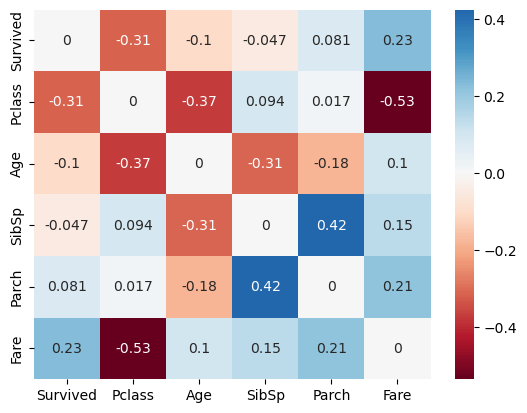

In [98]:
np.fill_diagonal(corr.values, 0)
sns.heatmap(corr, annot=True, cmap='RdBu', center=0);

In [99]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         141
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       549
Embarked      2
dtype: int64

In [100]:
train.groupby('Sex')[target].mean()

Sex
female    0.744939
male      0.191398
Name: Survived, dtype: float64

In [101]:
train.groupby(target)['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,439.0,22.789292,31.810613,0.0,7.89165,10.5,26.0000,263.0000
1,273.0,46.453923,67.781291,0.0,11.24170,26.0,56.4958,512.3292


In [102]:
train.loc[train['Fare'] == 0]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
674,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0,NaN,S
597,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
271,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
481,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
263,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
302,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
179,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
806,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0,A36,S
466,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
732,0,2,"Knight, Mr. Robert J",male,NaN,0,0,239855,0.0,NaN,S


# Pipeline

In [103]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attributes]

In [104]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


In [108]:
num_pp = Pipeline([
    ('dataselect', DataSelect(num))
    , ('impute', SimpleImputer(strategy='median'))
    , ('scaler', StandardScaler())
])

cat_pp = Pipeline([
    ('dataselect', DataSelect(['Sex']))
    , ('encoder', OneHotEncoder(sparse_output=False))
])

pipe = FeatureUnion([
    ('num', num_pp)
    , ('cat', cat_pp)
])

pipe.fit(train)
train_pre = pipe.transform(train)
test_pre = pipe.transform(test)

# Select Model

In [112]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [119]:
cls_log = LogisticRegression()
print(
    'train:', cross_val_score(cls_log, train_pre, train[target]).mean()
    , 'test:', cross_val_score(cls_log, test_pre, test[target]).mean()
)


train: 0.7907318034078596 test: 0.7768253968253969


In [121]:
cls_svc = SVC()
print(
    'train:', cross_val_score(cls_svc, train_pre, train[target]).mean()
    , 'test:', cross_val_score(cls_svc, test_pre, test[target]).mean()
)


train: 0.8286516300600807 test: 0.7987301587301587


In [122]:
cls_ran = RandomForestClassifier()
print(
    'train:', cross_val_score(cls_ran, train_pre, train[target]).mean()
    , 'test:', cross_val_score(cls_ran, test_pre, test[target]).mean()
)


train: 0.8019403132079189 test: 0.8158730158730159


In [133]:
model_base = cls_ran

# Fine Tuning Model

In [134]:
model_base.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [136]:
from sklearn.model_selection import GridSearchCV
params = {
    'random_state': [0]
    , 'n_estimators': [100, 200, 300]
    , 'max_depth': [5, 7, 9]
}
grid = GridSearchCV(model_base, param_grid=params)
grid.fit(train_pre, train[target])
grid.best_params_

{'max_depth': 5, 'n_estimators': 200, 'random_state': 0}

In [156]:
model_tune = RandomForestClassifier(random_state=0, n_estimators=200, max_depth=5)
model_tune.fit(train_pre, train[target]);

# Validation

In [150]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict

In [151]:
def getScores(m, X, y):
    prediction = cross_val_predict(m, X, y)
    return {
        'accuracy': accuracy_score(y, prediction)
        , 'precision': precision_score(y, prediction)
        , 'recall': recall_score(y, prediction)
        , 'f1_score': f1_score(y, prediction)
        , 'roc_auc_score': roc_auc_score(y, prediction)
    }

scores = pd.DataFrame({
    'tr_base': getScores(model_base, train_pre, train[target])
    , 'tr_tune': getScores(model_tune, train_pre, train[target])
    , 'te_base': getScores(model_base, test_pre, test[target])
    , 'te_tune': getScores(model_tune, test_pre, test[target])
})

scores['tr_diff'] = (scores['tr_tune'] / scores['tr_base'] -1) * 100
scores['te_diff'] = (scores['te_tune'] / scores['te_base'] -1) * 100
scores.drop(['tr_base', 'te_base'], axis=1, inplace=True)
scores

,tr_tune,te_tune,tr_diff,te_diff
accuracy,0.825843,0.804469,1.730104,-0.689655
precision,0.828194,0.793103,7.202755,-1.724138
recall,0.688645,0.666667,-4.568528,0.000000
f1_score,0.752000,0.724409,0.775635,-0.787402
roc_auc_score,0.799903,0.778788,0.648833,-0.580271


# Submission

In [159]:
samp = pd.read_csv('/kaggle/input/titanic/test.csv')

pd.DataFrame({
    'PassengerId': samp['PassengerId']
    , 'Survived': model_tune.predict(pipe.transform(samp))
}).to_csv('submission.csv', index=False)